In [1]:
from http_directory import resolve_link, ListingParser, download_directory
import numpy as np
import matplotlib.pyplot as plt
from kernels import Kernels
from smoothnk import smoothn
%matplotlib inline

getdata = False

if getdata:
    url = 'http://gws-access.cems.rl.ac.uk/public/globalbedo/.stackXY2/'
    download_directory(url, 'tmp')


In [6]:
years = [ 2005 ]
months = np.arange(1,13)
#months = [6]
QA_OK = np.array([8, 72, 136, 200, 1032, 1288, 2056, 2120, 2184,  2248])

for year in years:
    nsamples = 0
    for month in months:
        fname = "MODIS_BRDF/hainich_%04d_%02d.txt" % ( year, month )
        reflt = np.loadtxt ( fname, delimiter=";", usecols=np.arange(15,22) )/10000.
        nsamples += reflt.shape[0]
            
    doys = np.empty ( nsamples )
    qa = np.empty ( nsamples )
    qa_pass = np.empty ( nsamples )
    refl = np.empty ( (nsamples,7) )
    angs = np.empty ( (nsamples,4) )

    istart = 0
    for month in months:
        print "->%d, %d<-" % ( year, month )
        fname = "MODIS_BRDF/hainich_%04d_%02d.txt" % ( year, month )
        doyt = np.loadtxt ( fname, delimiter=";", usecols=[2] ) - year*1000
        n = len(doyt)
        doys[istart:(istart+n)] = doyt
        reflt = np.loadtxt ( fname, delimiter=";", usecols=np.arange(15,22) )/10000.
        refl[istart:(istart+n),:] = reflt
        angst = np.loadtxt ( fname, delimiter=";", usecols=np.arange (11,15))/100.
        angs[istart:(istart+n), :] = angst
        #angs are sza,vza,saa,vaa
        qa1kt = np.loadtxt ( fname, delimiter=";", usecols=[10] )
        qa[istart:(istart+n)] = qa1kt

        qa_passt = np.logical_or.reduce([qa1kt == x for x in QA_OK ])
        qa_passt = qa_passt.astype(np.int8)
        qa_pass[istart:(istart+n)] = qa_passt
        istart = istart + n

    #qa_pass[~np.logical_and(doys>=80,doys<96)] = False
    K_obs =  Kernels( angs[:,1], angs[:,0], angs[:,2] - angs[:,3], \
            LiType='Sparse', doIntegrals=False, \
            normalise=1, RecipFlag=True, RossHS=False, MODISSPARSE=True, \
            RossType='Thick')
    li = K_obs.Li
    ross = K_obs.Ross
        

->2005, 1<-
->2005, 2<-
->2005, 3<-
->2005, 4<-
->2005, 5<-
->2005, 6<-
->2005, 7<-
->2005, 8<-
->2005, 9<-
->2005, 10<-
->2005, 11<-
->2005, 12<-


In [7]:
r = np.array(refl[qa_pass.astype(bool)])
r0 = np.array(refl[qa_pass.astype(bool)]) >0
k1 = np.array([ross[qa_pass.astype(bool)]]*7).T
k2 = np.array([li[qa_pass.astype(bool)]]*7).T
k0 = np.array(np.ones_like(k1))
doy = np.array([doys[qa_pass.astype(bool)]])[0].astype(int)
print r.shape,k1.shape

alldoys = np.arange(0,365)
# expand array
nb = r.shape[1]
k00_ = np.zeros((365,)+(nb,))
k01_ = np.zeros_like(k00_)
k02_ = np.zeros_like(k00_)
k11_ = np.zeros_like(k00_)
k12_ = np.zeros_like(k00_)
k22_ = np.zeros_like(k00_)

rk0_ = np.zeros((365,)+(nb,))
rk1_ = np.zeros_like(k00_)
rk2_ = np.zeros_like(k00_)

for i,d in enumerate(doy):
    k00_[d] += 1
    k01_[d] += k1[i]
    k02_[d] += k2[i]
    k11_[d] += k1[i]*k1[i]
    k12_[d] += k1[i]*k2[i]
    k22_[d] += k2[i]*k2[i]
    rk0_[d] += r[i]
    rk1_[d] += r[i]*k1[i]
    rk2_[d] += r[i]*k2[i]
    
D = [k00_,k01_,k02_,k11_,k12_,k22_,rk0_,rk1_,rk2_]    
    
print k00_.shape

(162, 7) (162, 7)
(365, 7)


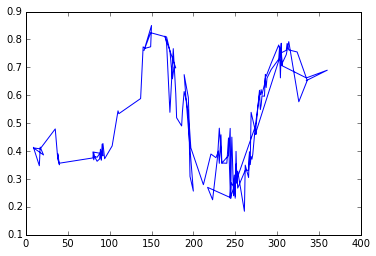

In [11]:
plt.plot(doy,(r[:,1]-r[:,0])/(r[:,1]+r[:,0]))

In [21]:
NIR = np.array([0.085,0.693,-0.146,0.176,0.146,0,0.043])
NIRoff = -0.0021
NIR = np.array([0.,1,0,0,0,0,0.])
NIRoff = 0.

#for dd in D:
#    print (np.dot(dd,NIR) + NIRoff).shape

In [22]:

result = []
dresult = []
for d in xrange(0,365,8):
    try:
        mask = np.logical_and(alldoys>=d,alldoys<d+16)
    except:
        mask = alldoys>=d
    k00,k01,k02,k11,k12,k22,rk0,rk1,rk2  = [np.dot(dd[mask],NIR)+NIRoff for dd in D]
    if k00.sum(axis=-1) >= 12:
        M = np.array([[k00,k01,k02],[k01,k11,k12],[k02,k12,k22]])
        a = np.array([rk0,rk1,rk2])
        #print d,np.linalg.lstsq(M.sum(axis=2),a.sum(axis=1))[0]
        result.append([np.linalg.lstsq(M.sum(axis=2),a.sum(axis=1))[0]])
        dresult.append(d)
result = np.array(result)
dresult = np.array(dresult)

print result.shape

(11, 1, 3)


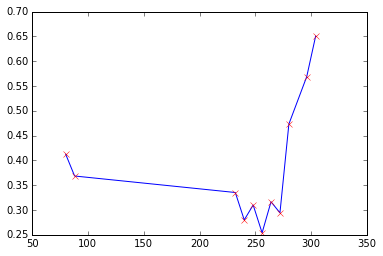

In [23]:
plt.plot(dresult,result[:,0,0])
plt.plot(dresult,result[:,0,0],'rx')


#plt.ylim(0,.5)

In [ ]:

np.array(refl[qa_pass.astype(bool)])
r0 = np.array(refl[qa_pass.astype(bool)]) >0
k1 = np.array([ross[qa_pass.astype(bool)]]*7).T
k2 = np.array([li[qa_pass.astype(bool)]]*7).T


dataset = np.zeros((rk.shape[0],)+(365,)+(rk.shape[2],))
print doy
for i,d in enumerate(doy):
    dataset[:,d,:] += rk[:,i,:]
print dataset.shape

In [311]:
refl =  dataset[0,:,6]
ross = dataset[1,:,6]
li =  dataset[2,:,6]

K = np.array([np.ones_like(ross),ross,li])
M = np.dot(K,K.T)
a = np.dot(K,refl)
print M,a

print np.linalg.lstsq(M,a)[0]


[[  3.65000000e+02   6.94501488e-01  -2.69478184e+01]
 [  6.94501488e-01   2.14911711e-01  -1.65173628e+00]
 [ -2.69478184e+01  -1.65173628e+00   8.35615401e+01]] [  4.3277       0.23224015 -13.28195573]
[ 0.00020018 -0.16642351 -0.16217328]


In [280]:
z = smoothn(dataset,axis=1,isrobust=True,s=10)
print z[1]
num = z[0]
denom = num[0]
result = num/denom

10


[-0.05196238  0.84871361  0.02882429]


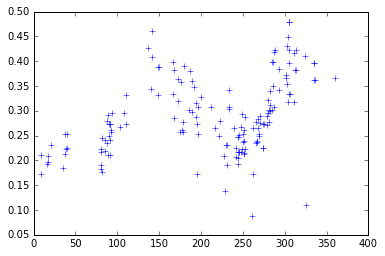

In [281]:
rhs = result[1:4]
lhs =  np.array([[result[4],result[5],result[6]],\
       [result[5],result[7],result[8]],\
       [result[6],result[8],result[9]]])
params = np.zeros_like(rhs)
rhs_ = rhs.sum(axis=1)
lhs_ = lhs.sum(axis=2)
b = 1
print np.linalg.lstsq(lhs_[:,:,b],rhs_[:,0])[0]
plt.plot(doy,r[:,b],'+')

In [282]:
for b in [7]:
    for d in xrange(0,365,8):
        try:
            M_ = lhs[:,:,d:d+8,b]
            a_ = rhs[:,d:d+8,b]
        except:
            M_ = lhs[:,:,d:,b]
            a_ = rhs[:,d:,b] 
        n = M_.shape[2]
        M_ = M_.sum(axis=2)
        a_ = a_.sum(axis=1)
        if n > 7:
            params[:,d,b] = np.linalg.lstsq(M_,a_)[0]

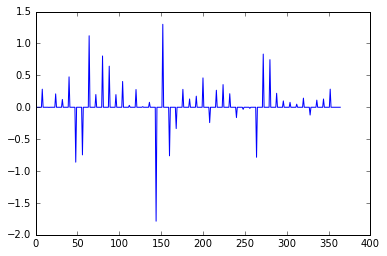

In [283]:
plt.plot(params[0,:,1])

In [271]:
for b in xrange(7):
    for d in xrange(365):
        M = lhs[:,:,d,b]
        a = rhs[:,d,b]
        params[:,d,b] = np.linalg.lstsq(M,a)[0]
        

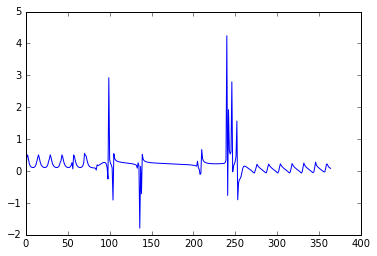

In [272]:
plt.plot(params[0,:,1])
#plt.ylim(0,1)

In [169]:
rhs.shape

(3, 365, 7)